# Measuring Transport Accessibility

A simple example using `tracc` ~~for the Boston region~~

In [4]:
#import sys
#sys.path.append("..")

import tracc
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib

%matplotlib inline

Load in the destination data. ~~For this example, these are job counts by block group from the the LEHD and SNAP grocery stores.~~

In [51]:
# dfo = pd.merge(
#         pd.read_csv("test_data/boston/destination_employment_lehd.csv"),
#         pd.read_csv("test_data/boston/destination_groceries_snap.csv"),
#         how = "outer",
#         left_on = "block_group_id",
#         right_on = "GEOID"
# )

# dfo = pd.read_csv("./../data/bres_jobs_tynewear.csv")
# dfo.head()

dfo = pd.merge(pd.read_csv("./../data/bres_jobs_tynewear.csv"),
               pd.read_csv("./../data/gis/tynewear_gs_accesspoints_lsoas.csv"),
               how = "outer",
               left_on = "LSOA11CD",
               right_on = "LSOA11CD")
dfo.head()


,LSOA11CD,jobs,n_access
0,E01008246,75.0,1
1,E01008247,40.0,14
2,E01008248,1000.0,26
3,E01008249,600.0,15
4,E01008250,100.0,9


~~Create a supply object (i.e. a dataset of destinations), for only the columns in which we want to compute accessibility for. In this case, all jobs from the LEHD (var C000), and SNAP grocery stores.~~

In [50]:
# dfo = tracc.supply(
#     supply_df = dfo,
#     columns = ["block_group_id","C000","snap"]
#     )
# dfo.data.head()

Now let's load in travel time data. Here we load in transit travel times that were previously computed in OpenTripPlanner (capped at 120 minutes) for June 30, 2020.

In [52]:
df_timetravel = pd.read_csv("./../data/traveltime_matrix_tynewearTRANSIT.csv")
df_timetravel.head()
dft = tracc.costs(df_timetravel)
dft.data.travel_time = dft.data.travel_time / 60 # converting time from seconds to minutes
dft.data.travel_time = dft.data.travel_time.round(1) # rounding to just one decimal place
dft.data.head()

,origin,destination,walk_distance,travel_time,boardings
0,E01008162,E01008162,12.000000,0.1,0
1,E01008162,E01008588,500.914707,45.1,1
2,E01008162,E01008510,682.106774,34.7,2
3,E01008162,E01008707,549.132617,44.5,2
4,E01008162,E01008184,762.776955,56.2,2


Computing impedance function based on a 45 minute travel time threshold 

In [53]:
dft.impedence_calc(
    cost_column = "travel_time",
    impedence_func = "cumulative",
    impedence_func_params = 45,
    output_col_name = "fCij_c45",
    prune_output = False
)
dft.data.head()

,origin,destination,walk_distance,travel_time,boardings,fCij_c45
0,E01008162,E01008162,12.000000,0.1,0,1
1,E01008162,E01008588,500.914707,45.1,1,0
2,E01008162,E01008510,682.106774,34.7,2,1
3,E01008162,E01008707,549.132617,44.5,2,1
4,E01008162,E01008184,762.776955,56.2,2,0


Setting up the accessibility object. This includes joining the destination data to the travel time data

In [54]:
acc = tracc.accessibility(
        travelcosts_df = dft.data,
        supply_df = dfo,
        travelcosts_ids = ["origin","destination"],
        supply_ids = "LSOA11CD"
    )
acc.data.head()

,origin,destination,walk_distance,travel_time,boardings,fCij_c45,LSOA11CD,jobs,n_access
0,E01008162,E01008162,12.000000,0.1,0,1,E01008162,125.0,24
1,E01008162,E01008588,500.914707,45.1,1,0,E01008588,450.0,0
2,E01008162,E01008510,682.106774,34.7,2,1,E01008510,175.0,5
3,E01008162,E01008707,549.132617,44.5,2,1,E01008707,100.0,0
4,E01008162,E01008184,762.776955,56.2,2,0,E01008184,300.0,10


Measuring potential accessibility to jobs, using a 45 minute cumulative impedance function.

In [55]:
dfa = acc.potential(
        opportunity = "jobs",
        impedence = "fCij_c45"
        )
dfa.head()

,origin,A_jobs_fCij_c45
0,E01008162,332905.0
1,E01008163,324185.0
2,E01008164,264950.0
3,E01008165,267425.0
4,E01008166,364775.0


Let's try to visualize the result, first by loading in shape for the ~~Block Groups~~ _LSOAs/admin boundaries_, joining our output ~~to block groups~~, then plotting

In [56]:
bg = gpd.read_file("./../data/gis/LSOA_(Dec_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3/")
bg = bg.merge(dfa,
              left_on='LSOA11CD',
              right_on = "origin",
              how = "left")

<AxesSubplot:>

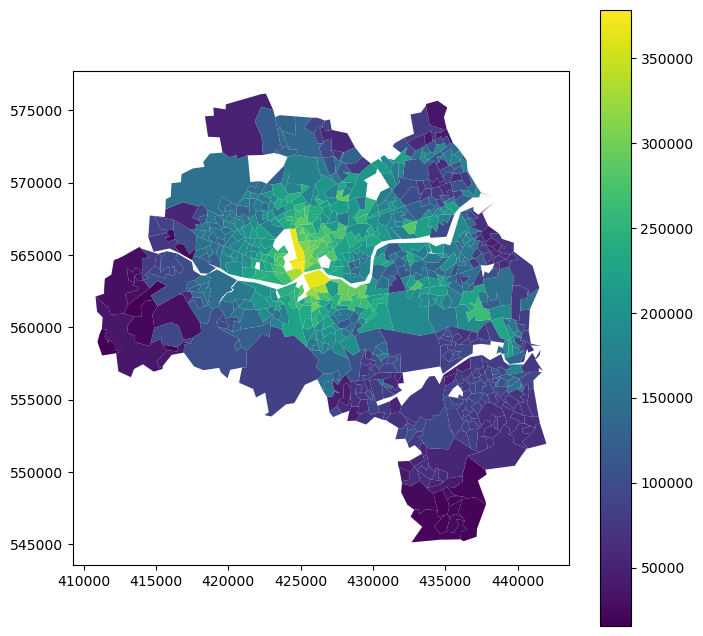

In [57]:
bg.plot(column='A_jobs_fCij_c45',
        figsize=(8, 8),
        # scheme='quantiles',
        legend=True)
# ,
#         legend_kwds={'loc': 'upper left'});

Now let's try to measure access to ~~grocery stores~~ green spaces, based on minimum travel time
(e.g. what is the minimum travel time to reach the closest (1) green space ~~grocery stores~~)


In [62]:
dfm = acc.mintravelcost(
        travelcost = "travel_time",
        opportunity = "n_access",
        min_n = 1
        )
dfm.head()

,LSOA11CD,A_mintravelcost_travel_time_n_access_2
0,E01008162,0.1
1,E01008163,0.5
2,E01008164,0.5
3,E01008165,1.5
4,E01008166,0.3


In [63]:
bg2 = gpd.read_file("./../data/gis/LSOA_(Dec_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3/")
bg2 = bg2.merge(dfm,
              left_on='LSOA11CD',
              right_on = "LSOA11CD",
              how = "left")
bg2.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,A_mintravelcost_travel_time_n_access_2
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.629 181906.496, 532248.250 18...",NaN
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.814 181786.892, 532248.250 18...",NaN
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.068 182068.422, 532419.592 18...",NaN
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,212682.404259,2028.654904,a14c307a-874c-4862-828a-3b1486cc21ea,"POLYGON ((533604.245 181418.129, 533743.689 18...",NaN
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,130551.387161,1716.896118,65121a2d-3d2b-4935-9712-690f2993cfd2,"POLYGON ((545271.918 184183.948, 545296.314 18...",NaN


KeyError: 'A_mintravelcost_travel_time_n_access_1'

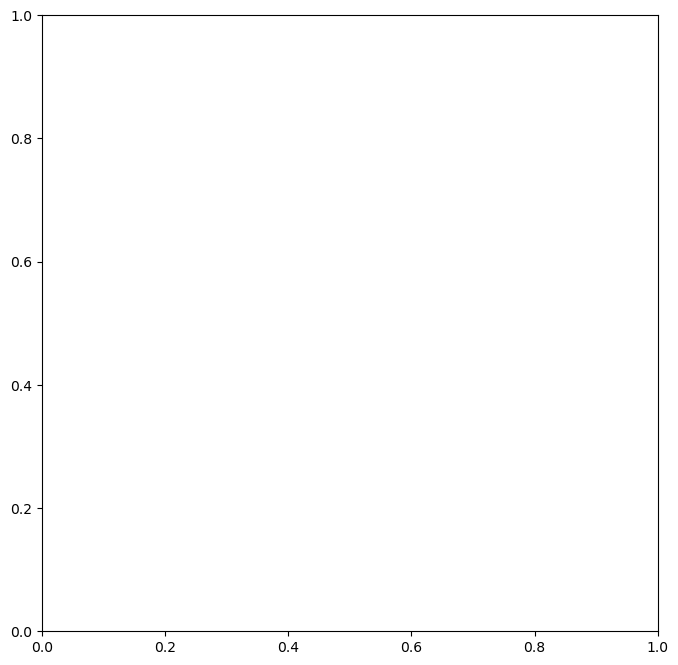

In [65]:
bg2.plot(column='A_mintravelcost_travel_time_n_access_1',
         figsize=(8, 8),
         scheme='NaturalBreaks',
         legend=True,
         legend_kwds={'loc': 'lower left'});